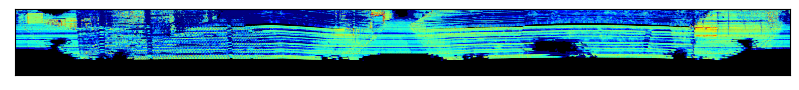

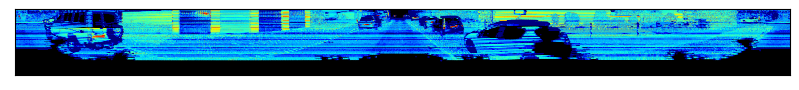

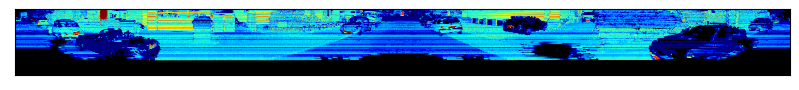

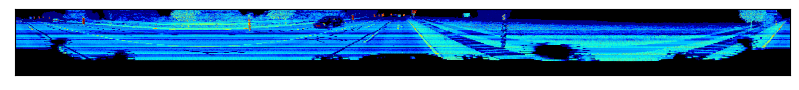

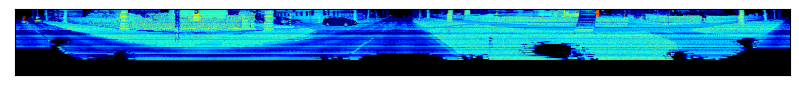

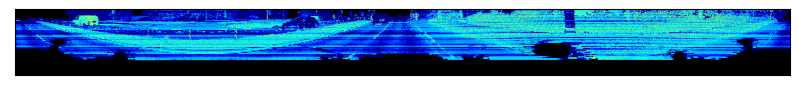

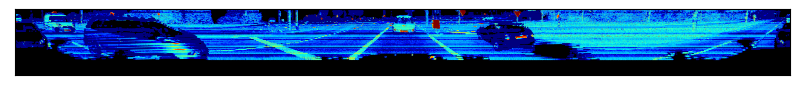

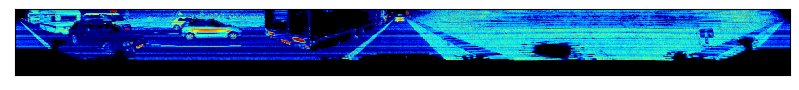

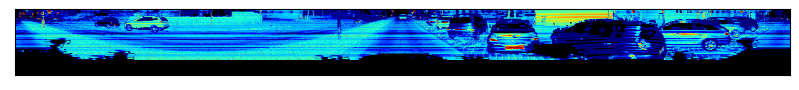

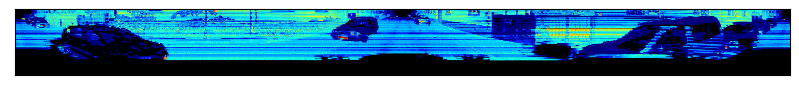

In [4]:
img_id=200
import numpy as np
import os
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.patches as patches
import yaml
import pandas as pd
from li import *
from pylab import *
from matplotlib.lines import Line2D
import matplotlib.image as mpimg
    
 
def transform_to_img(xmin, xmax, ymin, ymax,
                      res=0.1,
                      side_range=(-20., 20-0.05),  # left-most to right-most
                      fwd_range=(0., 40.-0.05),  # back-most to forward-most
                      ):
 
    xmin_img = -ymax/res - side_range[0]/res
    xmax_img = -ymin/res - side_range[0]/res
    ymin_img = -xmax/res + fwd_range[1]/res
    ymax_img = -xmin/res + fwd_range[1]/res
    
    return xmin_img, xmax_img, ymin_img, ymax_img
       

def lidar_to_2d_front_view(img_id,
                           r,
                           points,
                           v_res,
                           h_res,
                           v_fov,
                           val="depth",
                           cmap="jet",
                           y_fudge=0.0,
                           saveto=None,
                           figsize=None,
                           ):
    """ Takes points in 3D space from LIDAR data and projects them to a 2D
        "front view" image, and saves that image.
    Args:
        points: (np array)
            The numpy array containing the lidar points.
            The shape should be Nx4
            - Where N is the number of points, and
            - each point is specified by 4 values (x, y, z, reflectance)
        v_res: (float)
            vertical resolution of the lidar sensor used.
        h_res: (float)
            horizontal resolution of the lidar sensor used.
        v_fov: (tuple of two floats)
            (minimum_negative_angle, max_positive_angle)
        val: (str)
            What value to use to encode the points that get plotted.
            One of {"depth", "height", "reflectance"}
        cmap: (str)
            Color map to use to color code the `val` values.
            NOTE: Must be a value accepted by matplotlib's scatter function
            Examples: "jet", "gray"
        saveto: (str or None)
            If a string is provided, it saves the image as this filename.
            If None, then it just shows the image.
        y_fudge: (float)
            A hacky fudge factor to use if the theoretical calculations of
            vertical range do not match the actual data.
            For a Velodyne HDL 64E, set this value to 5.
    """

    # DUMMY PROOFING
    assert len(v_fov) ==2, "v_fov must be list/tuple of length 2"
    assert v_fov[0] <= 0, "first element in v_fov must be 0 or negative"
    assert val in {"depth", "height", "reflectance"}, \
        'val must be one of {"depth", "height", "reflectance"}'


    x_lidar = points[:, 0]
    y_lidar = points[:, 1]
    z_lidar = points[:, 2]
    r_lidar = points[:, 3] # Reflectance
    # Distance relative to origin when looked from top
    #d_lidar = np.sqrt(x_lidar ** 2 + y_lidar ** 2)
    # Absolute distance relative to origin
    d_lidar = np.sqrt(x_lidar ** 2 + y_lidar ** 2, z_lidar ** 2)

    v_fov_total = -v_fov[0] + v_fov[1]

    # Convert to Radians
    v_res_rad = v_res * (np.pi/180)
    h_res_rad = h_res * (np.pi/180)

    # PROJECT INTO IMAGE COORDINATES
    x_img = np.arctan2(-y_lidar, x_lidar)/ h_res_rad
    y_img = np.arctan2(z_lidar, d_lidar)/ v_res_rad

    # SHIFT COORDINATES TO MAKE 0,0 THE MINIMUM
    x_min = -360.0 / h_res / 2  # Theoretical min x value based on sensor specs
    x_img -= x_min              # Shift
    x_max = 360.0 / h_res       # Theoretical max x value after shifting

    y_min = v_fov[0] / v_res    # theoretical min y value based on sensor specs
    y_img -= y_min              # Shift
    y_max = v_fov_total / v_res # Theoretical max x value after shifting

    y_max += y_fudge            # Fudge factor if the calculations based on
                                # spec sheet do not match the range of
                                # angles collected by in the data.

    # WHAT DATA TO USE TO ENCODE THE VALUE FOR EACH PIXEL
    if val == "reflectance":
        pixel_values = r_lidar
    elif val == "height":
        pixel_values = z_lidar
    else:
        pixel_values = -d_lidar

    # PLOT THE IMAGE
    cmap = "jet"            # Color map to use
    dpi = 100          # Image resolution
    if figsize:
        fig, ax = plt.subplots(figsize=figsize, dpi=dpi)    
    else:
        fig, ax = plt.subplots(figsize=(x_max/dpi, y_max/dpi), dpi=dpi)
    ax.scatter(x_img,y_img, s=1, c=pixel_values, linewidths=0, alpha=1, cmap=cmap)
    ax.set_facecolor((0, 0, 0)) # Set regions with no points to black
    ax.axis('scaled')              # {equal, scaled}
    ax.xaxis.set_visible(False)    # Do not draw axis tick marks
    ax.yaxis.set_visible(False)    # Do not draw axis tick marks
    plt.xlim([0, x_max])   # prevent drawing empty space outside of horizontal FOV
    plt.ylim([0, y_max])   # prevent drawing empty space outside of vertical FOV
    output_dir="/home/mcw/outputs_f"
    #plt.savefig('{}/{}'.format(output_dir,str(r))) 
    
    
for r in range(30,40):
    val1=str(r).zfill(6)
    path = '/home/mcw/Documents/Kitti/training/velodyne/{}.bin'.format(val1)
    points = np.fromfile(path, dtype=np.float32).reshape(-1, 4) 
    
    calib = Calibration('/home/mcw/Documents/Kitti/training/calib/{}.txt'.format(val1))
    img = mpimg.imread('/home/mcw/Documents/Kitti/training/image_2/{}.png'.format(val1))
    #plt.imshow(img)
    #fig, ax = plt.subplots(figsize=(8, 8))


    #fig = plt.figure(figsize=(10,10)) 
    #ax=fig.add_subplot(projection='3d')
    #ax.view_init(45,150) 
    HRES = 0.35                    
    VRES = 0.4                     # vertical resolution
    VFOV = (-32, 1)            # Field of view (-ve, +ve) along vertical axis
    Y_FUDGE = 5
    i=120
    lidar_to_2d_front_view(i,r,points, v_res=VRES, h_res=HRES, v_fov=VFOV, val="reflectance", saveto=True,y_fudge=Y_FUDGE, figsize=(10,10))
    #top = point_cloud_2_top(points, zres=1.0, side_range=(-40., 40-0.05), fwd_range=(0., 80.-0.05))
    #top = np.array(top, dtype = np.float32)
    #print (top)
    #ax.imshow(top, aspect='equal')
    #print(top.shape)
    #df =read_detection('/home/mcw/Documents/Kitti/training/label_2/{}.txt'.format(val1))
    #output_dir="/home/mcw/outputs_f"
    #plt.savefig('{}/{}'.format(output_dir,str(i)))

#plt.show()
#plt.savefig('/home/mcw/Documents/Lidar_Boundingbox_output.png')
#draw_point_cloud(ax, points, axes=[0, 1])
#draw_box(ax,(corners_3d_velo),axes=[0,1],color='r')

 
        

In [21]:
import imageio
import os

path = '/home/mcw/outputs_final/'
images = []

for filename in f:
    if filename.endswith(".png"):
        file_directory = os.path.join(path, filename)
        print(file_directory)
        #print(imageio.imread(file_directory))
        images.append(imageio.imread(file_directory))
imageio.mimsave('movie_output_1.gif', images,duration=0.3)

/home/mcw/outputs_f/35.png
/home/mcw/outputs_f/34.png
/home/mcw/outputs_f/31.png
/home/mcw/outputs_f/30.png
/home/mcw/outputs_f/36.png
/home/mcw/outputs_f/32.png
/home/mcw/outputs_f/38.png
/home/mcw/outputs_f/39.png
/home/mcw/outputs_f/33.png
/home/mcw/outputs_f/37.png
